In [ ]:
# Install the Kaggle library
!pip install kaggle

# Import the files library from google.colab
from google.colab import files

# Upload the kaggle.json file
print("Please upload the kaggle.json file downloaded from your Kaggle account")
files.upload()

# Create a Kaggle directory and move the json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set the permissions for the file
!chmod 600 ~/.kaggle/kaggle.json


Please upload the kaggle.json file downloaded from your Kaggle account


Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset using the Kaggle API
# The ! allows you to run command-line instructions
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# Unzip the downloaded file
!unzip -q brain-mri-images-for-brain-tumor-detection.zip


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 872MB/s]


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and paths
IMG_WIDTH = 128
IMG_HEIGHT = 128
dataset_folder = '' # Images are in the root directory after unzipping

# Load images and labels
data = []
labels = []

# Load 'yes' tumor images
for filename in os.listdir(os.path.join(dataset_folder, 'yes')):
    img_path = os.path.join(dataset_folder, 'yes', filename)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        data.append(img)
        labels.append(1) # 1 for 'yes' (tumor)

# Load 'no' tumor images
for filename in os.listdir(os.path.join(dataset_folder, 'no')):
    img_path = os.path.join(dataset_folder, 'no', filename)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        data.append(img)
        labels.append(0) # 0 for 'no' (no tumor)

# Convert to numpy arrays and normalize
data = np.array(data) / 255.0
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (202, 128, 128, 3)
Testing data shape: (51, 128, 128, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5), # Helps prevent overfitting

    Dense(1, activation='sigmoid') # Sigmoid for binary classification (tumor or no tumor)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_split=0.1, # Use part of the training data for validation
                    batch_size=32)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5181 - loss: 1.1603 - val_accuracy: 0.7619 - val_loss: 0.5730
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8272 - loss: 0.5251 - val_accuracy: 0.6667 - val_loss: 0.6105
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7810 - loss: 0.4719 - val_accuracy: 0.7619 - val_loss: 0.4900
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7730 - loss: 0.4825 - val_accuracy: 0.8095 - val_loss: 0.4930
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8156 - loss: 0.4457 - val_accuracy: 0.8095 - val_loss: 0.4781
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8375 - loss: 0.3847 - val_accuracy: 0.8095 - val_loss: 0.4850
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8441 - loss: 0.3474 - val_accuracy: 0.8095 - val_loss: 0.4725
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8902 - loss: 0.3343 - val_accuracy: 0.7619 - val_loss: 0.4920
Epoch 9/20
6

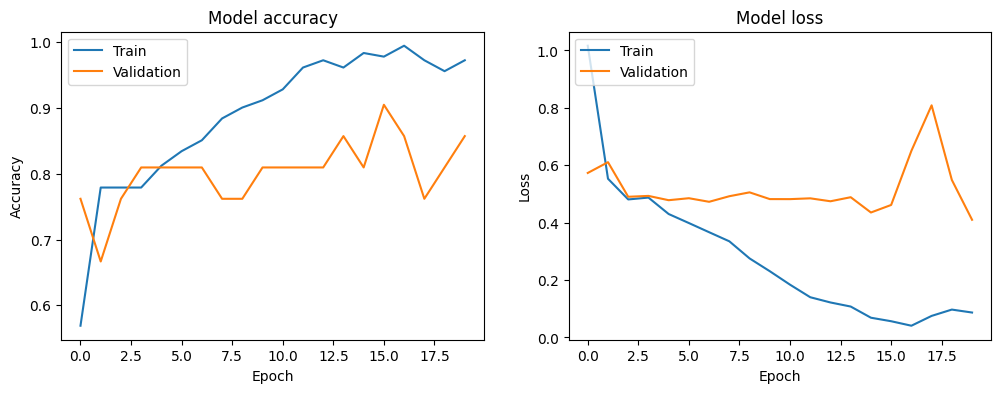

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.8407 - loss: 0.2830

Test accuracy: 0.8235


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


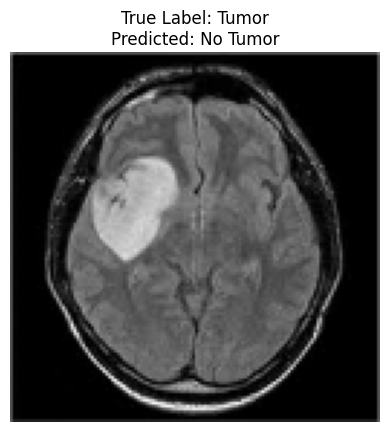

In [ ]:
# Select a random image from the test set
image_index = np.random.randint(0, len(X_test))
sample_image = X_test[image_index]
true_label = y_test[image_index]

# The model expects a batch of images, so we add a dimension
sample_image_batch = np.expand_dims(sample_image, axis=0)

# Make a prediction
prediction = model.predict(sample_image_batch)
predicted_label = 1 if prediction[0][0] > 0.5 else 0

# Display the image and the result
plt.imshow(sample_image)
plt.title(f"True Label: {'Tumor' if true_label == 1 else 'No Tumor'}\nPredicted: {'Tumor' if predicted_label == 1 else 'No Tumor'}")
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities for the positive class (tumor)
y_pred_proba = model.predict(X_test)

# Get predicted classes by applying a threshold of 0.5
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()

# Ensure y_test is also a 1D array
y_test_flat = y_test.flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step


In [ ]:
print("Classification Report:\n")
print(classification_report(y_test_flat, y_pred_classes, target_names=['No Tumor', 'Tumor']))

Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.86      0.75      0.80        24
       Tumor       0.80      0.89      0.84        27

    accuracy                           0.82        51
   macro avg       0.83      0.82      0.82        51
weighted avg       0.83      0.82      0.82        51



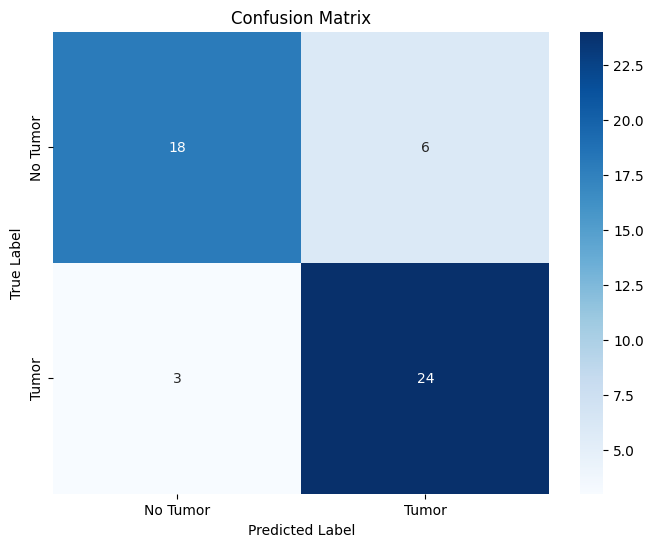

In [ ]:
cm = confusion_matrix(y_test_flat, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

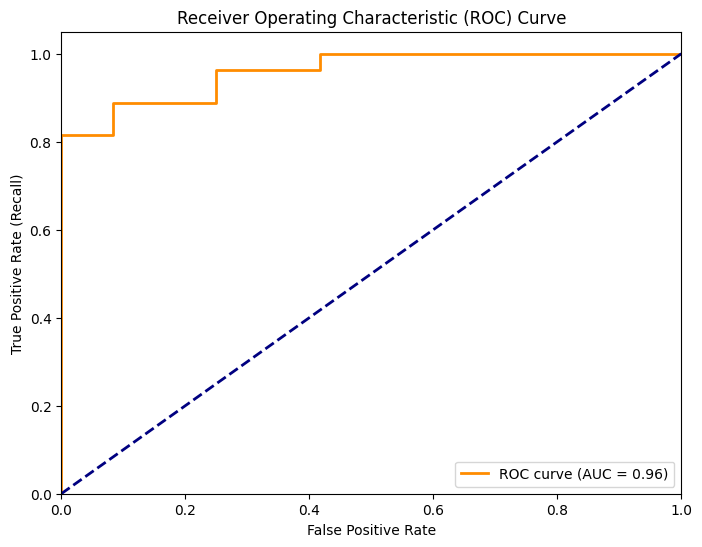

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Dashed line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# Get the filename of the uploaded file
if len(uploaded.keys()) > 0:
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make a prediction
    predict_single_image(test_image_path, model)
else:
    print("No file uploaded.")


Please upload an MRI image to test:


No file uploaded.


In [ ]:
# Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# Get the filename of the uploaded file
if len(uploaded.keys()) > 0:
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make a prediction
    predict_single_image(test_image_path, model)
else:
    print("No file uploaded.")


Please upload an MRI image to test:


No file uploaded.


In [ ]:
# Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# Get the filename of the uploaded file
if len(uploaded.keys()) > 0:
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make a prediction
    predict_single_image(test_image_path, model)
else:
    print("No file uploaded.")

Please upload an MRI image to test:


Saving 4 no.jpg to 4 no.jpg


NameError: name 'predict_single_image' is not defined

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- Ensure your model is already trained and available in the 'model' variable ---

# Define the image dimensions you used for training
IMG_WIDTH = 128
IMG_HEIGHT = 128

def predict_single_image(image_path, model):
    """
    Loads an image, preprocesses it, and uses the trained model to predict
    if it contains a brain tumor.

    Args:
        image_path (str): The path to the image file.
        model (keras.Model): The trained Keras model.

    Returns:
        None. Displays the image with the prediction.
    """
    # 1. Load the image using OpenCV
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    # Display the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for display
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # 2. Preprocess the image (same as training)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) # Resize
    img_array = np.array(img) / 255.0               # Normalize

    # 3. Reshape for the model (add batch dimension)
    # The model expects input shape: (batch_size, height, width, channels)
    # Our image shape is (128, 128, 3), so we add a dimension at the start
    img_batch = np.expand_dims(img_array, axis=0)
    print(f"Image shape after preprocessing and reshaping: {img_batch.shape}")

    # 4. Make a prediction
    prediction_proba = model.predict(img_batch)
    prediction_class = (prediction_proba > 0.5).astype(int)[0][0]

    # 5. Interpret the result
    probability_of_tumor = prediction_proba[0][0] * 100

    if prediction_class == 1:
        result = "Result: Tumor Detected"
    else:
        result = "Result: No Tumor Detected"

    print(f"\n{result}")
    print(f"Confidence Score: {probability_of_tumor:.2f}%")

    return

Please upload an MRI image to test:


Saving Y4.jpg to Y4.jpg


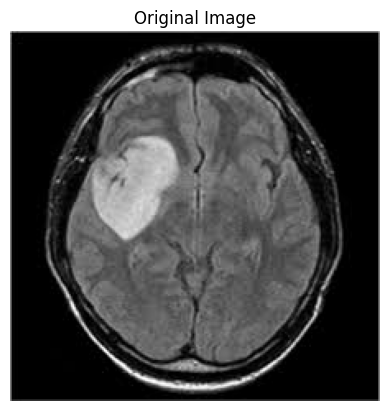

Image shape after preprocessing and reshaping: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Result: No Tumor Detected
Confidence Score: 27.62%


In [ ]:
# Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# Get the filename of the uploaded file
if len(uploaded.keys()) > 0:
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make a prediction
    predict_single_image(test_image_path, model)
else:
    print("No file uploaded.")


Please upload an MRI image to test:


Saving 1 no.jpeg to 1 no.jpeg


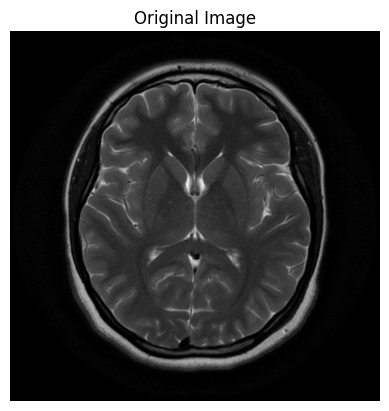

Image shape after preprocessing and reshaping: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Result: No Tumor Detected
Confidence Score: 0.00%


In [ ]:
# Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# Get the filename of the uploaded file
if len(uploaded.keys()) > 0:
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make a prediction
    predict_single_image(test_image_path, model)
else:
    print("No file uploaded.")

Please upload an MRI image to test:


Saving Y153.jpg to Y153.jpg


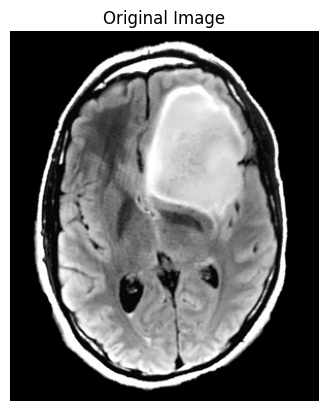

Image shape after preprocessing and reshaping: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Result: Tumor Detected
Confidence Score: 97.20%


In [ ]:
# Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# Get the filename of the uploaded file
if len(uploaded.keys()) > 0:
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make a prediction
    predict_single_image(test_image_path, model)
else:
    print("No file uploaded.")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images up to 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by 10%
    height_shift_range=0.1, # Randomly shift images vertically by 10%
    shear_range=0.1,        # Apply shear transformations
    zoom_range=0.1,         # Randomly zoom in on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # How to fill in new pixels after a rotation or shift
)

# NOTE: We do not augment the validation/test data!
# The model should be evaluated on the original, untouched images.
validation_datagen = ImageDataGenerator() # No augmentation, just rescaling if needed

# You would then train your model using train_datagen.flow()
# (See the "Putting it All Together" section below for the full code)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# First, we need to know the labels of your training data (y_train)
# Let's assume y_train is the array of labels (0s and 1s) from before

# Calculate the class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary to pass to the model
class_weight_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weight_dict}")
# Example Output: {0: 0.9, 1: 1.1} -> This tells the model to treat
# class 1 (Tumor) as ~1.1 times more important than class 0 (No Tumor)

Class Weights: {0: np.float64(1.364864864864865), 1: np.float64(0.7890625)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build a slightly deeper CNN model
deeper_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(), # Helps stabilize and speed up training
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'), # An extra convolutional layer
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

deeper_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deeper_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,109,953 (19.49 MB)

 Trainable params: 5,108,993 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load a pre-trained model (e.g., VGG16) without its final classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze the layers of the base model so they are not re-trained
for layer in base_model.layers:
    layer.trainable = False

# Add our custom classification layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
transfer_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,910,017 (72.14 MB)

 Trainable params: 4,195,329 (16.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# 1. Prepare your data (X_train, X_test, y_train, y_test) as before

# 2. Create the Data Augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# 3. Calculate Class Weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# 4. Use your original model (or the deeper one)
# Let's re-compile it to be safe
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Train the model using the generator and class weights
history_tuned = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32, # Number of batches per epoch
    epochs=30, # May need more epochs with augmentation
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict # <-- The important new parameter
)

# 6. IMPORTANT: Re-evaluate your model!
# Check the new classification report and confusion matrix.
# You should see the number of False Negatives decrease.
y_pred_tuned = (model.predict(X_test) > 0.5).astype(int)
print("\nNew Classification Report:\n")
print(classification_report(y_test, y_pred_tuned, target_names=['No Tumor', 'Tumor']))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6894 - loss: 0.8277 - val_accuracy: 0.7647 - val_loss: 0.4684
Epoch 2/30
1/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6562 - loss: 0.5794

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6562 - loss: 0.5794 - val_accuracy: 0.7843 - val_loss: 0.4789
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6654 - loss: 0.6477 - val_accuracy: 0.8235 - val_loss: 0.4780
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7812 - loss: 0.6163 - val_accuracy: 0.8039 - val_loss: 0.4657
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6663 - loss: 0.5761 - val_accuracy: 0.8039 - val_loss: 0.4739
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.7500 - loss: 0.5897 - val_accuracy: 0.8039 - val_loss: 0.4791
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7761 - loss: 0.5783 - val_accuracy: 0.7451 - val_loss: 0.5965
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7500 - loss: 0.6238 - val_accuracy: 0.8039 - val_loss: 0.5118
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7382 - loss: 0.5569 - val_accuracy: 0.8039 - val_loss: 0.4822
Epoch 10/30
6/6

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- Make sure your fine-tuned model is available in the 'model' variable ---

# Define the image dimensions (must be the same as training)
IMG_WIDTH = 128
IMG_HEIGHT = 128

def predict_and_visualize(image_path, model_to_test):
    """
    Loads an image, preprocesses it, and uses the trained model to predict
    if it contains a brain tumor. It then displays the result.

    Args:
        image_path (str): The path to the image file.
        model_to_test (keras.Model): The trained Keras model.
    """
    # 1. Load the image using OpenCV
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    # 2. Preprocess the image
    # The new image must go through the exact same steps as the training data
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) # Resize
    img_array = np.array(img_resized) / 255.0               # Normalize

    # 3. Reshape for the model
    # The model expects a batch of images, so we add a batch dimension
    # Shape changes from (128, 128, 3) to (1, 128, 128, 3)
    img_batch = np.expand_dims(img_array, axis=0)

    # 4. Make a prediction
    prediction_proba = model_to_test.predict(img_batch)
    prediction_class = (prediction_proba > 0.5).astype(int)[0][0]

    # 5. Interpret the result and display
    probability_of_tumor = prediction_proba[0][0] * 100

    if prediction_class == 1:
        result_text = f"Result: Tumor Detected ({probability_of_tumor:.2f}%)"
        result_color = 'red'
    else:
        result_text = f"Result: No Tumor Detected ({100 - probability_of_tumor:.2f}%)"
        result_color = 'green'

    # Display the image with the result
    # We use cv2.cvtColor to show the correct colors with matplotlib
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(result_text, color=result_color, fontsize=14)
    plt.axis('off')
    plt.show()

Please upload an MRI image to test:


Saving Y4.jpg to Y4 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


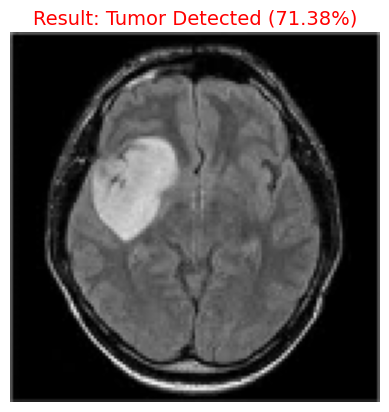

In [ ]:
# --- Use this cell to upload and check your image ---

# 1. Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# 2. Get the filename and call the prediction function
if len(uploaded.keys()) > 0:
    # Get the path of the file you just uploaded
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make and display the prediction
    # We pass the 'model' variable which now holds your fine-tuned model
    predict_and_visualize(test_image_path, model)
else:
    print("\nNo file was uploaded.")

Please upload an MRI image to test:


Saving Y6.jpg to Y6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


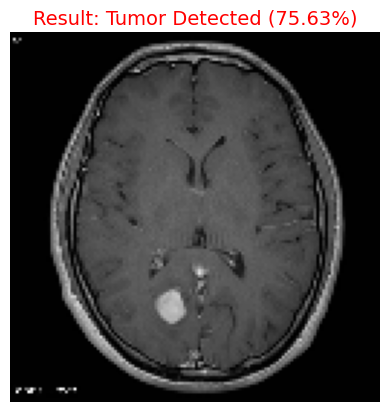

In [ ]:
# --- Use this cell to upload and check your image ---

# 1. Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# 2. Get the filename and call the prediction function
if len(uploaded.keys()) > 0:
    # Get the path of the file you just uploaded
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make and display the prediction
    # We pass the 'model' variable which now holds your fine-tuned model
    predict_and_visualize(test_image_path, model)
else:
    print("\nNo file was uploaded.")

Please upload an MRI image to test:


Saving 3 no.jpg to 3 no.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


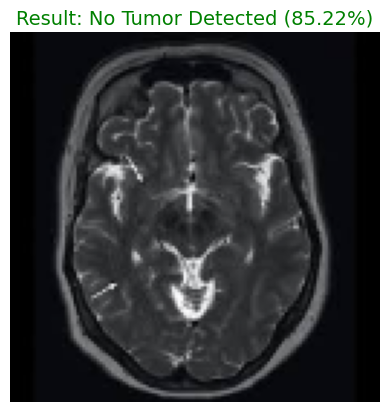

In [ ]:
# --- Use this cell to upload and check your image ---

# 1. Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# 2. Get the filename and call the prediction function
if len(uploaded.keys()) > 0:
    # Get the path of the file you just uploaded
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make and display the prediction
    # We pass the 'model' variable which now holds your fine-tuned model
    predict_and_visualize(test_image_path, model)
else:
    print("\nNo file was uploaded.")

Please upload an MRI image to test:


Saving 21 no.jpg to 21 no.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


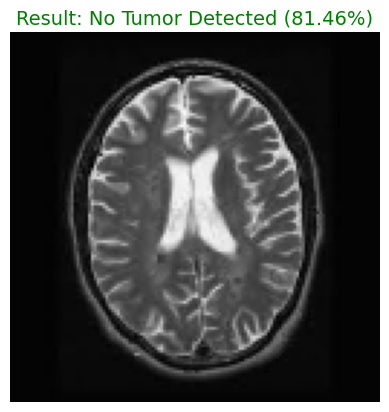

In [30]:
# --- Use this cell to upload and check your image ---

# 1. Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# 2. Get the filename and call the prediction function
if len(uploaded.keys()) > 0:
    # Get the path of the file you just uploaded
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make and display the prediction
    # We pass the 'model' variable which now holds your fine-tuned model
    predict_and_visualize(test_image_path, model)
else:
    print("\nNo file was uploaded.")

Please upload an MRI image to test:


Saving No16.jpg to No16.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


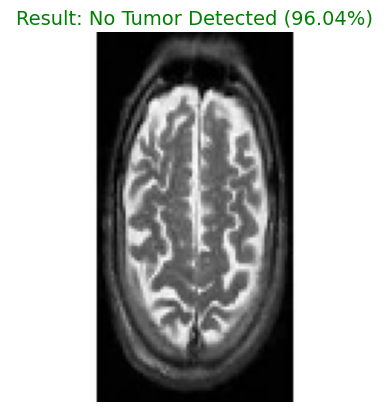

In [31]:
# --- Use this cell to upload and check your image ---

# 1. Use Google Colab's file uploader
print("Please upload an MRI image to test:")
uploaded = files.upload()

# 2. Get the filename and call the prediction function
if len(uploaded.keys()) > 0:
    # Get the path of the file you just uploaded
    test_image_path = list(uploaded.keys())[0]

    # Call the function to make and display the prediction
    # We pass the 'model' variable which now holds your fine-tuned model
    predict_and_visualize(test_image_path, model)
else:
    print("\nNo file was uploaded.")